In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

### Set Random seed

This is to ensure results are repoducibile and consistent across runs

In [2]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST("./data", train=False, transform=transform, download=True)

train_size = int(0.9 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_subset, val_dataset = random_split(train_dataset, [train_size, val_size])     

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Training subset: {len(train_subset)}")
print(f"Test images: {len(test_dataset)}")

classes = train_dataset.classes

Training images: 60000
Validation images: 6000
Training subset: 54000
Test images: 10000


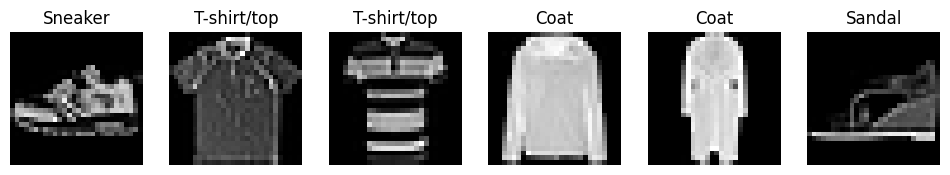

In [4]:
def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.show()

show_samples()

### **VeryDeepResNetCNN Architecture (Residual Conv + Residual FC)**

- **24 convolution layers** with BatchNorm + ReLU  
  - Organized into **3 residual conv blocks**:  
    - Block 1: Conv0–Conv5 → Skip → **Pool**  
    - Block 2: Conv6–Conv11 → Skip → **Pool**  
    - Block 3: Conv12–Conv17 → Skip → **Pool**, then Conv18–Conv23 → Skip  

- **Feature map size:**  
  - 28×28 → 14×14 → 7×7 → 3×3 after pool operations  
  - Final conv output: **128 × 3 × 3**

- **24 fully connected layers**, grouped into **6 residual FC blocks** (4 per block):  
  - Flatten (128·3·3 = 1152) → FC × 24 with internal residual connections

- **Output:**  
  - Final linear layer → **10-class logits**

**Overall flow:**  
Residual Conv Block 1 → Pool →  
Residual Conv Block 2 → Pool →  
Residual Conv Block 3 → Pool → Conv → Skip →  
Flatten → 6× Residual FC Blocks → Output layer


In [5]:
class VeryDeepResNetCNN(nn.Module):
    """24 conv layers grouped into 3 residual blocks + 24 FC layers."""
    def __init__(self):
        super().__init__()

        # Convolution Layers
        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList()

        in_channels = 1
        channels = 128

        for _ in range(24):
            self.convs.append(nn.Conv2d(in_channels, channels, 3, padding=1))
            self.bns.append(nn.BatchNorm2d(channels))
            in_channels = channels

        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        flattened = 128 * 3 * 3  
        hidden_dim = 256

        self.fcs = nn.ModuleList()
        in_dim = flattened

        for _ in range(24):
            self.fcs.append(nn.Linear(in_dim, hidden_dim))
            in_dim = hidden_dim

        self.output = nn.Linear(hidden_dim, 10)


    # Residual Block Helper
    def residual_block_conv(self, x, start, end):
        """Apply conv[start:end] with BN+ReLU, then block-level skip."""
        identity = x

        for i in range(start, end):
            x = self.convs[i](x)
            x = self.bns[i](x)
            x = F.relu(x)

        if x.shape == identity.shape:
            x = x + identity

        return x


    def residual_block_fc(self, x, layers):
        """Apply a group of FC layers, then skip once."""
        identity = x

        for fc in layers:
            x = F.relu(fc(x))

        if x.shape == identity.shape:
            x = x + identity

        return x


    def forward(self, x):

        # Block 1: conv 0–5 → skip → pool
        x = self.residual_block_conv(x, 0, 6)
        x = self.pool(x)

        # Block 2: conv 6–11 → skip → pool
        x = self.residual_block_conv(x, 6, 12)
        x = self.pool(x)

        # Block 3: conv 12–23 → skip (no pool)
        x = self.residual_block_conv(x, 12, 18)
        x = self.pool(x)

        x = self.residual_block_conv(x, 18, 24)

        # Flatten
        x = x.view(x.size(0), -1)

        # Group FC layers in blocks of 4 (24 layers → 6 blocks)
        fc_groups = [
            self.fcs[0:4], self.fcs[4:8], self.fcs[8:12],
            self.fcs[12:16], self.fcs[16:20], self.fcs[20:24]
        ]

        for group in fc_groups:
            x = self.residual_block_fc(x, group)

        return self.output(x)



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = VeryDeepResNetCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [7]:
patience = 5              # number of epochs to wait for improvement
best_val_loss = np.inf
epochs_no_improve = 0
max_epochs = 1000         # just a safety limit
best_model_state = None

for epoch in range(1, max_epochs + 1):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # -------- Validation Step --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:   # Make sure you have a val_loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Logic --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("\nEarly stopping triggered!")
        print(f"Best Validation Loss: {best_val_loss:.4f}")
        break

# Load the best model state
model.load_state_dict(best_model_state)
print("Restored best model parameters.")

Epoch 1 | Train Loss: 0.5014 | Val Loss: 0.3594
Epoch 2 | Train Loss: 0.3003 | Val Loss: 0.2860
Epoch 3 | Train Loss: 0.2553 | Val Loss: 0.2419
Epoch 4 | Train Loss: 0.2315 | Val Loss: 0.2859
  No improvement for 1 epoch(s).
Epoch 5 | Train Loss: 0.2075 | Val Loss: 0.2262
Epoch 6 | Train Loss: 0.1909 | Val Loss: 0.2017
Epoch 7 | Train Loss: 0.1769 | Val Loss: 0.2255
  No improvement for 1 epoch(s).
Epoch 8 | Train Loss: 0.1686 | Val Loss: 0.2113
  No improvement for 2 epoch(s).
Epoch 9 | Train Loss: 0.1545 | Val Loss: 0.2012
Epoch 10 | Train Loss: 0.1452 | Val Loss: 0.1952
Epoch 11 | Train Loss: 0.1339 | Val Loss: 0.2082
  No improvement for 1 epoch(s).
Epoch 12 | Train Loss: 0.1263 | Val Loss: 0.2027
  No improvement for 2 epoch(s).
Epoch 13 | Train Loss: 0.1165 | Val Loss: 0.2097
  No improvement for 3 epoch(s).
Epoch 14 | Train Loss: 0.1088 | Val Loss: 0.1992
  No improvement for 4 epoch(s).
Epoch 15 | Train Loss: 0.0942 | Val Loss: 0.2291
  No improvement for 5 epoch(s).

Early sto

In [8]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

mis_images = []
mis_preds = []
mis_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for img, pred, label in zip(images, predicted, labels):
            if pred != label:
                mis_images.append(img.cpu())
                mis_preds.append(pred.item())
                mis_labels.append(label.item())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")


Test Accuracy: 93.05%
F1 Score: 0.9309


<Figure size 1600x1200 with 0 Axes>

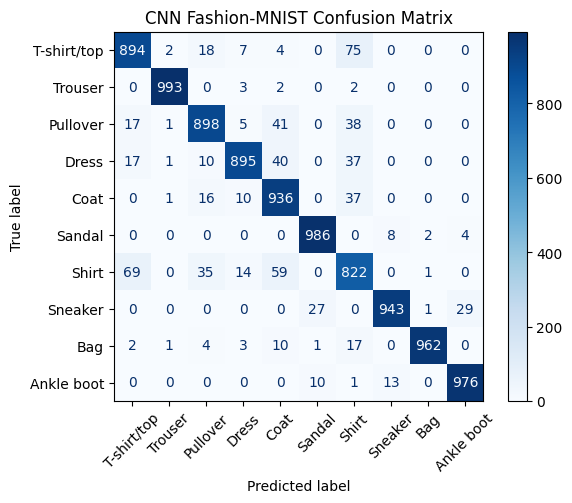

In [9]:

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(16, 12))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45)
plt.title("CNN Fashion-MNIST Confusion Matrix")
plt.show()


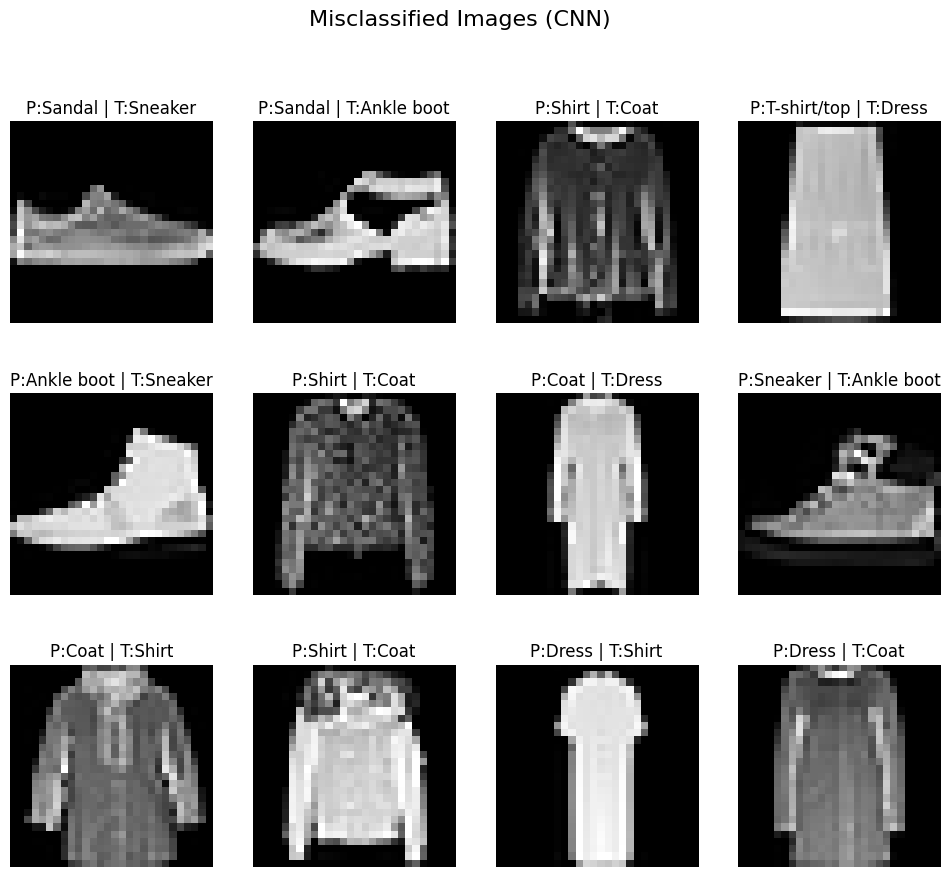

In [10]:

plt.figure(figsize=(12, 10))
num = 12
classes = test_dataset.classes

for i in range(num):
    plt.subplot(3, 4, i+1)
    plt.imshow(mis_images[i].squeeze(), cmap="gray")
    plt.title(f"P:{classes[mis_preds[i]]} | T:{classes[mis_labels[i]]}")
    plt.axis("off")

plt.suptitle("Misclassified Images (CNN)", fontsize=16)
plt.show()


## Result

The ResNet incorporated **Batch Normalization** after every convolution to normalize layer inputs, preventing internal covariate shift. Crucially, **Skip Connections** ($x+F(x)$) provided a direct path for gradients to flow, enabling the deepest model to achieve the highest accuracy (93.05%).